## Stable Diffusion fine tune with DreamBooth on SageMaker g4dn notebook
* Tested with ml.g4dn.xlarge SageMaker notebook, which has a NVIDIA T4 GPU with 16 GiB GPU memory.
* Content included training part and inference part.
* Major training codes were borrowed from [ShivamShrirao's repo](https://github.com/ShivamShrirao/diffusers/tree/main/examples/dreambooth) and most of inference codes were borrowed from [Philschmid's blog](https://www.philschmid.de/sagemaker-stable-diffusion).

## 1. SageMaker training part

### 1.1 Install dependencies

In [ ]:
%%writefile requirements.txt
accelerate
transformers>=4.25.1
ftfy
tensorboard
modelcards
natsort
safetensors

In [ ]:
!pip install -U pip
!pip install torch==2.0.0+cu118 torchvision==0.15.1+cu118 --extra-index-url https://download.pytorch.org/whl/cu118
!pip install git+https://github.com/ShivamShrirao/diffusers.git
!pip install -U -r requirements.txt

### 1.2 Install GPU memory optimization libraries

In [ ]:
!pip install bitsandbytes==0.35.4 # newly updated version of bitsandbytes made images into garbage, so freeze the version for now
!pip install -U triton
# !pip install xformers
!pip install xformers==0.0.18  # Changed to new version 0.0.18 in order to be suitable for notebook instance in g5 type

### 1.3 Initialize an Accelerate environment 

In [ ]:
from accelerate.utils import write_basic_config
write_basic_config()

### 1.4 Get training scripts from ShivamShrirao's repo

In [5]:
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py

### 1.5 Train a modle for generating a person in cyberpunk style  
* "Style" training example, you can also train the model for "object" or "person"
* More information you can refer to [ShivamShrirao's repo](https://github.com/ShivamShrirao/diffusers/tree/main/examples/dreambooth)
* Training parameters are also optimized according to [this thread](https://github.com/d8ahazard/sd_dreambooth_extension/discussions/547)

In [6]:
MODEL_NAME = "runwayml/stable-diffusion-v1-5" 
OUTPUT_DIR = "stable_diffusion_weights/dreambooth_fine_tune"
INSTANCE_DATA_DIR = "images/source"
IMAGES_OUTPTS = "images/outputs"
!mkdir -p $OUTPUT_DIR $INSTANCE_DATA_DIR $IMAGES_OUTPTS

In [ ]:
!git clone https://github.com/terrificdm/dreambooth-stablediffusion-sagemaker-notebook
!cp -r dreambooth-stablediffusion-sagemaker-notebook/images/source/* $INSTANCE_DATA_DIR

In [8]:
# Due to SageMaker upgrade notebook kernel recently, you might encounter error like "ImportError: /lib64/libstdc++.so.6: version `GLIBCXX_3.4.26' not found", use below scripts to avoid
!sudo rm -rf /lib64/libstdc++.so.6 /lib64/libstdc++.so.6
!sudo ln -s /home/ec2-user/anaconda3/envs/python3/lib/libstdc++.so.6 /lib64/libstdc++.so.6

In [9]:
!rm -rf /home/ec2-user/SageMaker/images/source/.ipynb_checkpoints

In [ ]:
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DATA_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="photo of cypk style" \
  --resolution=512 \
  --train_batch_size=2 \
  --train_text_encoder \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --gradient_checkpointing \
  --learning_rate=1.25e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=636 \
  # --save_interval=500 \

### 1.6 Mode inference testing

In [ ]:
from natsort import natsorted
from glob import glob
import os
WEIGHTS_DIR = natsorted(glob(OUTPUT_DIR + os.sep + "*"))[-1]
print(f"[*] WEIGHTS_DIR={WEIGHTS_DIR}")    

You have disabled the safety checker for <class 'diffusers_modules.git.lpw_stable_diffusion.StableDiffusionLongPromptWeightingPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

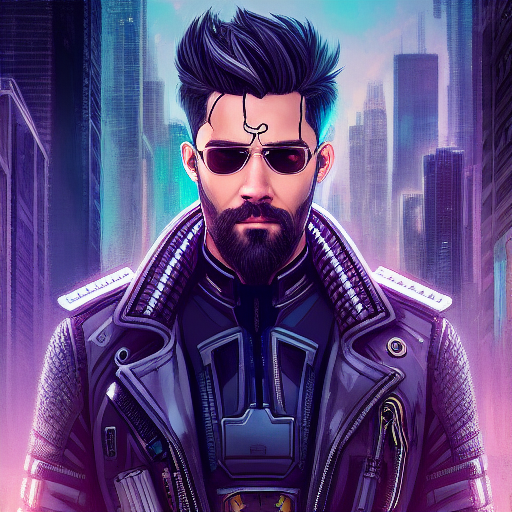

images/outputs/4775696148727397_2023-04-23 09:52:46.png



  0%|          | 0/20 [00:00<?, ?it/s]

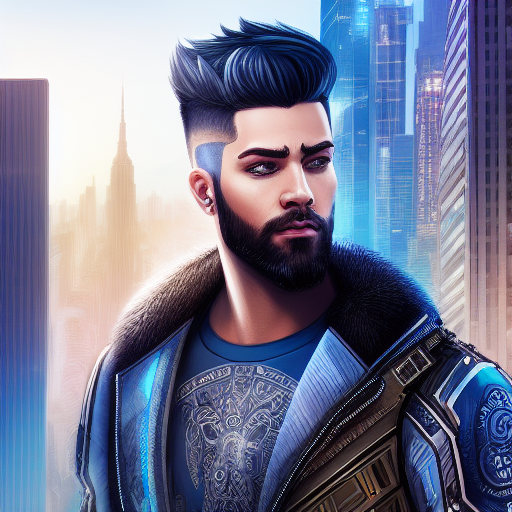

images/outputs/1731587654851151_2023-04-23 09:52:49.png


Seeds for generating images: [4775696148727397, 1731587654851151]



In [53]:
import torch
import datetime

from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
model_dir = WEIGHTS_DIR

scheduler = EulerAncestralDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")
generator = torch.Generator(device="cuda")
pipe = StableDiffusionPipeline.from_pretrained(model_dir, custom_pipeline="lpw_stable_diffusion", scheduler=scheduler, torch_dtype=torch.float16) # Add custom pipeline to support long prompt
pipe = pipe.to("cuda")
prompt = "portrait of cypk style man, handsome detailed face, intricate eyes, frontal view, upper body, city background, masterpiece, best quality, highly detailed"
negative_prompt = "lowres, worst quality, ugly, (disfigured), ((mutated hands, misshapen hands, mutated fingers, fused fingers):1.2), extra limbs, deformed legs, disfigured legs, text, logo, watermark"

num_images = 2
seeds = []
for _ in range(num_images):
    seed = generator.seed()
    seeds.append(seed)
    generator = generator.manual_seed(seed)
    image = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        height=512,
        width=512,
        num_images_per_prompt=1,
        num_inference_steps=20,
        guidance_scale=7.5,
        generator = generator
    ).images[0]
    display(image)
    now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    file_path = IMAGES_OUTPTS + "/" + str(seed) + "_" + str(now) + ".png"
    print(file_path + "\n")
    image.save(file_path)
    
# print(seeds)
print(f"\nSeeds for generating images: {seeds}\n")

  0%|          | 0/20 [00:00<?, ?it/s]

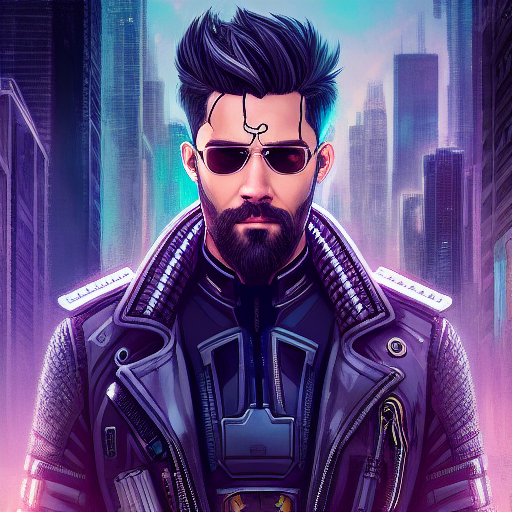

In [54]:
# Comment below codes, if you don't want to produce the same images again
seed = seeds[0] # use the first seed
generator.manual_seed(seed)
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    height=512,
    width=512,
    num_images_per_prompt=1,
    num_inference_steps=20,
    guidance_scale=7.5,
    generator = generator
).images[0]
display(image)

### 1.7 Use scripts to convert weights to ckpt to use in web UIs like AUTOMATIC1111
* For how to use "Stable Diffusion web UI" of AUTOMATIC1111, please refer to this [repo](https://github.com/AUTOMATIC1111/stable-diffusion-webui)
* DreamBooth plugin can also be implemented for "Stable Diffusion web UI" to fine tune the model
* You can also use other methods provided by webUI to fine tune the model.

In [14]:
# uncomment below codes if you want to generate ckpt file for web UI

# !wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py
# ckpt_path = WEIGHTS_DIR + "/model.ckpt"
# half_arg = ""
# #@markdown  Whether to convert to fp16, takes half the space (2GB).
# fp16 = False #@param {type: "boolean"}
# if fp16:
#     half_arg = "--half"
# !python convert_diffusers_to_original_stable_diffusion.py --model_path $WEIGHTS_DIR  --checkpoint_path $ckpt_path $half_arg
# print(f"[*] Converted ckpt saved at {ckpt_path}")

## 2. SageMaker inference part

### 2.1 Initialize SageMaker inference endpoint

In [ ]:
!pip install -U boto3
!pip install -U sagemaker

import boto3
import sagemaker

sess = sagemaker.Session()
sagemaker_session_bucket=None

if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()
    
try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")

### 2.2 Create "inference.py" script for SageMaker

In [16]:
!mkdir -p $WEIGHTS_DIR/code

In [ ]:
%%writefile $WEIGHTS_DIR/code/requirements.txt
diffusers
transformers>=4.25.1

In [ ]:
%%writefile $WEIGHTS_DIR/code/inference.py
import base64
import torch
from io import BytesIO
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler


def model_fn(model_dir):
    
    # Load stable diffusion and move it to the GPU
    scheduler = EulerAncestralDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")
    pipe = StableDiffusionPipeline.from_pretrained(model_dir, custom_pipeline="lpw_stable_diffusion", scheduler=scheduler, torch_dtype=torch.float16) # Add custom pipeline to support long prompt
    pipe = pipe.to("cuda")

    return pipe


def encoded_image(generator, seed, pipe, prompt, negative_prompt, height, width, num_inference_steps, guidance_scale):
    
    generator = generator.manual_seed(seed)
    generated_images = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        height=height,
        width=width,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator = generator
    )["images"][0]
    buffered = BytesIO()
    generated_images.save(buffered, format="PNG")
    encoded_image_response = base64.b64encode(buffered.getvalue()).decode()
    
    return encoded_image_response


def predict_fn(data, pipe):
    
    generator = torch.Generator(device="cuda")
    
    # get prompt & parameters
    prompt = data.pop("prompt", "")
    negative_prompt = data.pop("negative_prompt", "")
    # set valid HP for stable diffusion
    height = data.pop("height", 512)
    width = data.pop("width", 512)
    num_inference_steps = data.pop("num_inference_steps", 20)
    guidance_scale = data.pop("guidance_scale", 7.5)
    num_images_per_prompt = data.pop("num_images_per_prompt", 2)
    seed = data.pop("seed", "")
    
    seeds = []
    encoded_images = []
    
    # run generation with parameters
    if seed:
        seeds.append(seed)
        encoded_image_rt = encoded_image(generator, seed, pipe, prompt, negative_prompt, height, width, num_inference_steps, guidance_scale)
        encoded_images.append(encoded_image_rt)
        for _ in range(num_images_per_prompt-1):
            seed=seed+1
            seeds.append(seed)
            encoded_image_rt = encoded_image(generator, seed, pipe, prompt, negative_prompt, height, width, num_inference_steps, guidance_scale)
            encoded_images.append(encoded_image_rt)
    else:
        for _ in range(num_images_per_prompt):
            seed = generator.seed()
            seeds.append(seed)
            encoded_image_rt = encoded_image(generator, seed, pipe, prompt, negative_prompt, height, width, num_inference_steps, guidance_scale)
            encoded_images.append(encoded_image_rt)

    # create response
    return {"generated_images": encoded_images, "seeds": seeds}

### 2.3 Package SageMaker model.tar.gz artifact

In [ ]:
!tar --exclude *.ckpt --exclude *.tar.gz --use-compress-program=pigz -pcvf $WEIGHTS_DIR/model.tar.gz -C $WEIGHTS_DIR/ .

### 2.4 Upload the model to S3 bucket

In [20]:
from sagemaker.s3 import S3Uploader
s3_model_uri=S3Uploader.upload(local_path=f"{WEIGHTS_DIR}/model.tar.gz", desired_s3_uri=f"s3://{sess.default_bucket()}/stablediffusion-dreambooth/g4dn")

### 2.5 SageMaker real-time inference

#### 2.5.1 Deploy real-time inference endpoint

In [ ]:
from sagemaker.huggingface.model import HuggingFaceModel

# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
   model_data=s3_model_uri,      # path to your model and script
   role=role,                    # iam role with permissions to create an Endpoint
   transformers_version="4.17",  # transformers version used
   pytorch_version="1.10",       # pytorch version used
   py_version='py38',            # python version used
)

# deploy the endpoint
predictor = huggingface_model.deploy(
    initial_instance_count=1,
    instance_type="ml.g4dn.xlarge"
    )

#### 2.5.2 Generate images useing SageMaker real-time inference endpoint

In [22]:
from PIL import Image
from io import BytesIO
import base64
import datetime

# helper decoder
def decode_base64_image(image_string):
    base64_image = base64.b64decode(image_string)
    buffer = BytesIO(base64_image)
    return Image.open(buffer)

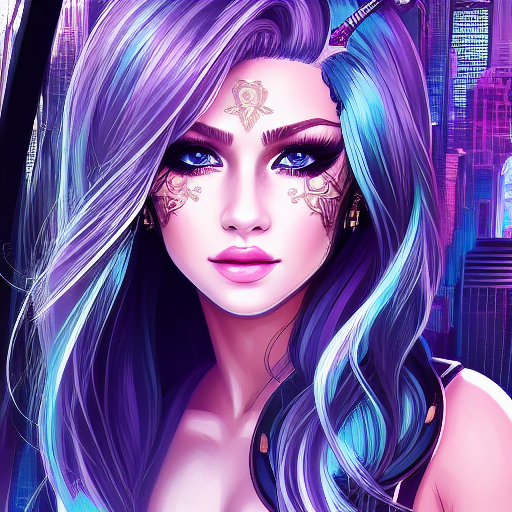

images/outputs/5070335801759708_2023-04-23 09:54:13.300486.png



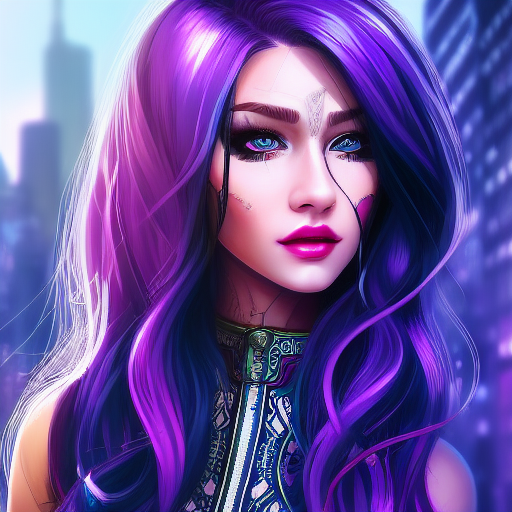

images/outputs/6483791933604278_2023-04-23 09:54:13.675661.png


Seeds for generating images: [5070335801759708, 6483791933604278]

Images saved in: s3://sagemaker-us-east-1-091166060467/stablediffusion-dreambooth/g4dn/images_output



In [57]:
# run prediction
response = predictor.predict(data={
    "prompt": "portrait of cypk style girl, pretty detailed face, intricate eyes, frontal view, upper body, city background, masterpiece, best quality, highly detailed",
    "negative_prompt": "lowres, worst quality, ugly, (disfigured), ((mutated hands, misshapen hands, mutated fingers, fused fingers):1.2), extra limbs, deformed legs, disfigured legs, text, logo, watermark",
    "height" : 512,
    "width" : 512,
    "num_images_per_prompt" : 2,
    # "seed" : 3904759173130859  # uncomment seed and replace with generated one, if you want to produce same
  }
)

# decode images
decoded_images = [decode_base64_image(image) for image in response["generated_images"]]

# visualize generation
i = 0
for image in decoded_images:
    display(image)
    seed = response['seeds'][i]
    i = i+1
    now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")
    file_path = IMAGES_OUTPTS + "/" + str(seed) + "_" + str(now) + ".png"
    print(file_path + "\n")
    image.save(file_path)
    # comment below code if you don't want to save in S3 bucket
    S3Uploader.upload(local_path=file_path, desired_s3_uri=f"s3://{sess.default_bucket()}/stablediffusion-dreambooth/g4dn/images_output")

# print(seeds)
print(f"\nSeeds for generating images: {response['seeds']}")
print(f"\nImages saved in: " + f"s3://{sess.default_bucket()}/stablediffusion-dreambooth/g4dn/images_output\n")


#### 2.5.3 Delete model and real-time endpoint

In [24]:
# uncomment below codes if you wanto to delete mode and endpoint for inference

# predictor.delete_model()
# predictor.delete_endpoint()

### 2.6 SageMaker asynchronous inference
* Refer to [Asynchronous Inference with Hugging Face's Transformers](https://github.com/huggingface/notebooks/blob/main/sagemaker/16_async_inference_hf_hub/sagemaker-notebook.ipynb) for more details
* Use predict_async() method

#### 2.6.1 Deploy asynchronous inference endpoint

In [ ]:
from sagemaker.huggingface.model import HuggingFaceModel
from sagemaker.async_inference.async_inference_config import AsyncInferenceConfig

# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
   model_data=s3_model_uri,      # path to your model and script
   role=role,                    # iam role with permissions to create an Endpoint
   transformers_version="4.17",  # transformers version used
   pytorch_version="1.10",       # pytorch version used
   py_version='py38',            # python version used
)

# create async endpoint configuration
async_config = AsyncInferenceConfig(
    output_path=f"s3://{sess.default_bucket()}/stablediffusion-dreambooth/g4dn/async_inference/output", # Where our results will be stored
    # notification_config={
            #   "SuccessTopic": "arn:aws:sns:us-east-2:123456789012:MyTopic",
            #   "ErrorTopic": "arn:aws:sns:us-east-2:123456789012:MyTopic",
    # }, #  Notification configuration
)

# deploy the endpoint endpoint
async_predictor = huggingface_model.deploy(
    initial_instance_count=1,
    instance_type="ml.g4dn.xlarge",
    async_inference_config=async_config
)

#### 2.6.2 Generate images useing SageMaker asynchronous inference endpoint

In [26]:
from PIL import Image
from io import BytesIO
import base64
import datetime

# helper decoder
def decode_base64_image(image_string):
    base64_image = base64.b64decode(image_string)
    buffer = BytesIO(base64_image)
    return Image.open(buffer)

Original Json strings response output path: s3://sagemaker-us-east-1-091166060467/stablediffusion-dreambooth/g4dn/async_inference/output/cec403f7-7ce7-4e2a-859b-b2c9164656ac.out

Start Polling to get response:


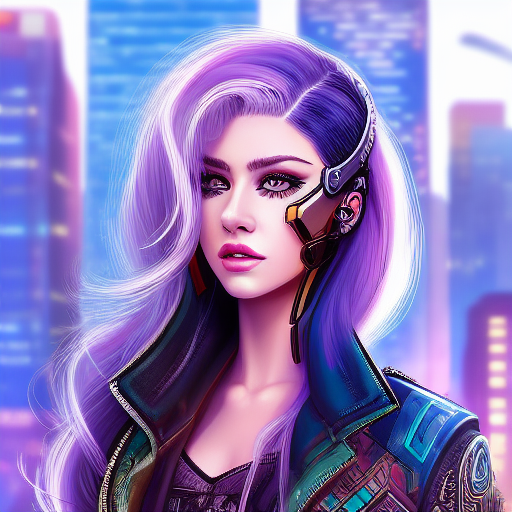

images/outputs/6633787494070417_2023-04-23 09:55:36.671697.png



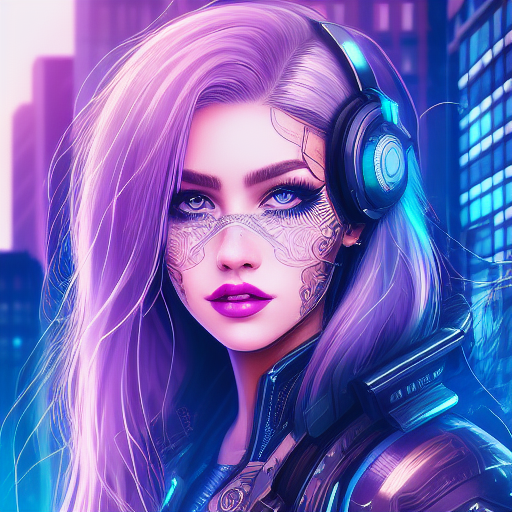

images/outputs/8662995164206345_2023-04-23 09:55:37.112880.png


Seeds for generating images: [6633787494070417, 8662995164206345]

Images saved in: s3://sagemaker-us-east-1-091166060467/stablediffusion-dreambooth/g4dn/images_output



In [61]:
from sagemaker.async_inference.waiter_config import WaiterConfig

response = async_predictor.predict_async(data={
    "prompt": "portrait of cypk style girl, pretty detailed face, intricate eyes, frontal view, upper body, city background, masterpiece, best quality, highly detailed",
    "negative_prompt": "lowres, worst quality, ugly, (disfigured), ((mutated hands, misshapen hands, mutated fingers, fused fingers):1.2), extra limbs, deformed legs, disfigured legs, text, logo, watermark",
    "height": 512,
    "width": 512,
    "num_images_per_prompt" : 2,
    "num_inference_steps": 20,
    # "seed" : 3904759173130859  # uncomment seed and replace with generated one, if you want to produce same
    }
)

print(f"Original Json strings response output path: {response.output_path}\n")
print("Start Polling to get response:")

config = WaiterConfig(
  max_attempts=5, #  number of attempts
  delay=10 #  time in seconds to wait between attempts
  )

response = response.get_result(config)

# decode images
decoded_images = [decode_base64_image(image) for image in response["generated_images"]]

# visualize generation
i = 0
for image in decoded_images:
    display(image)
    seed = response['seeds'][i]
    i = i+1
    now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")
    file_path = IMAGES_OUTPTS + "/" + str(seed) + "_" + str(now) + ".png"
    print(file_path + "\n")
    image.save(file_path)
    # comment below code if you don't want to save in S3 bucket
    S3Uploader.upload(local_path=file_path, desired_s3_uri=f"s3://{sess.default_bucket()}/stablediffusion-dreambooth/g4dn/images_output")

# print(seeds)
print(f"\nSeeds for generating images: {response['seeds']}")
print(f"\nImages saved in: " + f"s3://{sess.default_bucket()}/stablediffusion-dreambooth/g4dn/images_output\n")

#### 2.6.3 Autoscale (to zero) asynchronous inference endpoint

In [28]:
# application-autoscaling client
asg_client = boto3.client("application-autoscaling")

# This is the format in which application autoscaling references the endpoint
resource_id = f"endpoint/{async_predictor.endpoint_name}/variant/AllTraffic"

# Configure Autoscaling on asynchronous endpoint down to zero instances
response = asg_client.register_scalable_target(
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    MinCapacity=0,
    MaxCapacity=3,
)

response = asg_client.put_scaling_policy(
    PolicyName=f'Request-ScalingPolicy-{async_predictor.endpoint_name}',
    ServiceNamespace="sagemaker",  
    ResourceId=resource_id, 
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    PolicyType="TargetTrackingScaling",
    TargetTrackingScalingPolicyConfiguration={
        "TargetValue": 5.0, 
        "CustomizedMetricSpecification": {
            "MetricName": "ApproximateBacklogSizePerInstance",
            "Namespace": "AWS/SageMaker",
            "Dimensions": [{"Name": "EndpointName", "Value": async_predictor.endpoint_name}],
            "Statistic": "Average",
        },
        "ScaleInCooldown": 600, # duration until scale in begins (down to zero)
        "ScaleOutCooldown": 300 # duration between scale out attempts
    },
)

In [29]:
# Configure a scaling policy that quickly scales up from zero for new requests
response = asg_client.put_scaling_policy(
    PolicyName=f'HasBacklogWithoutCapacity-ScalingPolicy-{async_predictor.endpoint_name}',
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    PolicyType="StepScaling",
    StepScalingPolicyConfiguration={
        "AdjustmentType": "ChangeInCapacity",
        "MetricAggregationType": "Average",
        "Cooldown": 300, 
        "StepAdjustments":
        [ 
            {
              "MetricIntervalLowerBound": 0,
              "ScalingAdjustment": 1
            }
          ]
    },    
)

# CloudWatch client
cw_client = boto3.client("cloudwatch")

# Configure a CloudWatch alarm to trigger the above policy
response = cw_client.put_metric_alarm(
    AlarmName='RequestAagainstZeroCapacityAlarm',
    MetricName='HasBacklogWithoutCapacity',
    Namespace='AWS/SageMaker',
    Statistic='Average',
    EvaluationPeriods= 2,
    DatapointsToAlarm= 2,
    Threshold= 1,
    ComparisonOperator='GreaterThanOrEqualToThreshold',
    TreatMissingData='missing',
    Dimensions=[
        { 'Name': 'EndpointName', 'Value': async_predictor.endpoint_name },
    ],
    Period= 60,
    AlarmActions=[response['PolicyARN']]
)

#### 2.6.4 Delete model and asynchronous endpoint

In [30]:
# uncomment below codes if you wanto to delete mode and endpoint for inference

# response = asg_client.deregister_scalable_target(
#     ServiceNamespace='sagemaker',
#     ResourceId=resource_id,
#     ScalableDimension='sagemaker:variant:DesiredInstanceCount'
# )
# response = cw_client.delete_alarms(
#     AlarmNames=[
#         'RequestAagainstZeroCapacityAlarm',
#     ]
# )
# async_predictor.delete_model()
# async_predictor.delete_endpoint()